# Coursera Capstone Course

## About this repository
This repository represents the final assignment in the coursera certification course "IBM Data Science Professional Certificate" (See: https://www.coursera.org/professional-certificates/ibm-data-science).

# Main Notebook
To reduce clutter in the main notebook, I decided to split it in two components. This is the main notebook, where we use python to process and analyize the data we preprocessed in the last notebook.

In [101]:
# Imports

import math

import numpy as np
import pandas as pd
import folium

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print("Imports are done.")

Imports are done.


## Loading and analyzing the data

In [92]:
# Parameters for this project
# Main stations as point of reference (Stuttgarts Main Station has two components, therefore the list)
MAIN_STATIONS = ["Hauptbahnhof (oben)", "Hauptbahnhof (tief)"]

# Data paths
STATION_DATA = "data/stations.csv"
VENUE_DATA = "data/venues.csv"

In [93]:
# Load data (see the other notebook for more information)
df_stations = pd.read_csv(STATION_DATA)
df_venues = pd.read_csv(VENUE_DATA)

In [94]:
# Correct data types
cols = ["name", "place", "district", "type of transport", "lines"]
for c in cols:
    df_stations[c] = df_stations[c].astype("string")

df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               84 non-null     string 
 1   place              84 non-null     string 
 2   district           84 non-null     string 
 3   type of transport  84 non-null     string 
 4   lines              84 non-null     string 
 5   longitude          84 non-null     float64
 6   latitude           84 non-null     float64
dtypes: float64(2), string(5)
memory usage: 4.7 KB


In [95]:
# Correct data types
cols = ["station name", "venue id", "venue name", "venue address", "venue categories"]
for c in cols: df_venues[c] = df_venues[c].astype("string")

df_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station name      840 non-null    string 
 1   venue id          840 non-null    string 
 2   venue name        840 non-null    string 
 3   venue address     503 non-null    string 
 4   venue latitude    840 non-null    float64
 5   venue longitude   840 non-null    float64
 6   venue categories  840 non-null    string 
dtypes: float64(2), string(5)
memory usage: 46.1 KB


### Visualisation:
As a beginning I will start by visualising the data.
For this map: The red marker is the current location, the dark blue markers are train stations and the light blue markers are venues.

Note: Due to displaying problems, all occurences of 'ö', 'ä' and 'ü' will be replaced by 'oe', 'ae' and 'ue'.

In [97]:
## Create a map to see if the location data seems reasonable

# Create a copy of the original dataframes
df_plot_main = df_stations[["name", "latitude", "longitude"]]
df_plot_side = df_venues[["venue name", "venue latitude", "venue longitude"]]

# Center on Stuttgart Main Station
df_main_stations = df_plot_main[df_plot_main["name"].str.match(".*Hauptbahnhof.*")]
latitude = df_main_stations["latitude"].mean()
longitude = df_main_stations["longitude"].mean()

# Additional functions for proper formating
cleaner = lambda x: x.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue")

## Create the map and the labels
map = folium.Map(location = (latitude, longitude), zoom_start=10)

# Create markers for venues
for _, (name, lat, long) in df_plot_side.iterrows():
    label = folium.Popup(cleaner(name))
    
    folium.CircleMarker(
        location=(lat,long),
        popup=label,
        color="#00ccff",
        fill=True,
        radius=5,
        fill_opacity=1.0
    ).add_to(map)

# Create markers for stations
for _, (name, lat, long) in df_plot_main.iterrows():
    label = folium.Popup(cleaner(name))
    
    folium.CircleMarker(
        location=(lat,long),
        popup=label,
        color="blue",
        fill=True,
        radius=7,
        fill_opacity=0.2
    ).add_to(map)
    
# Create marker for the users current location
folium.CircleMarker(
    location=(latitude, longitude),
    popup=folium.Popup("Your Location"),
    color="red",
    fill=True,
    radius=10,
    fill_opacity=0.7
).add_to(map)

map

As you can see, there are some far outliers. Most likely these are the result of data sparcity, where no venues near a train station are known and therefore venues that lie pretty far outside were chosen by foursquare.

### Processing the data
In this section we will look into the data a bit. We will start by looking into the data to determine the top venues for each station.

In [98]:
df_stations["name"].head()

0    Nürnberger Straße
1           Leinfelden
2             Höfingen
3           Sommerrain
4            Malmsheim
Name: name, dtype: string

In [99]:
tmp = pd.concat([df_venues["station name"], pd.get_dummies(df_venues["venue categories"])], axis = 1)
df_venue_categories = tmp.groupby("station name").sum()

print(df_venue_categories.shape)
df_venue_categories.head()

(84, 208)


,ATM,Advertising Agency,Airport,Airport Service,Airport Terminal,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Trattoria/Osteria,Travel Agency,Turkish Restaurant,University,Unknown,Vacation Rental,Veterinarian,Vietnamese Restaurant,Vineyard,Well
station name,,,,,,,,,,,,,,,,,,,,,
Altbach,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Asperg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Backnang,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
Bad Cannstatt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Benningen (N),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0


In [100]:
tmp = df_venue_categories.T
df_top_per_stat = pd.DataFrame()
for c in tmp.columns:
    df_top_per_stat[c] = tmp[c].sort_values(ascending = False).index
    
df_top_per_stat = df_top_per_stat.head(10).T
df_top_per_stat.head()

,0,1,2,3,4,5,6,7,8,9
Altbach,Pub,German Restaurant,Department Store,Light Rail Station,Gas Station,Factory,Unknown,Platform,Supermarket,Doctor's Office
Asperg,Tattoo Parlor,Hotel,Building,Bakery,Doctor's Office,Light Rail Station,Bus Station,Parking,Pharmacy,Bar
Backnang,Middle School,Park,Bakery,Unknown,Conference Room,High School,Travel Agency,Train Station,Restaurant,Athletics & Sports
Bad Cannstatt,Platform,Grocery Store,Hostel,Cupcake Shop,Light Rail Station,Train Station,Bookstore,Snack Place,Bank,Doner Restaurant
Benningen (N),Unknown,Italian Restaurant,Light Rail Station,Brewery,City Hall,Historic Site,Museum,Gas Station,Diner,Dive Bar


We have now created a table with the top types of venues for each station. This will become useful later.

## Clusteringer the different train stations
We can use this processed data to train a classifier. This will enable us to group similar venues and stations together.

Shape of the input data: (84, 208)


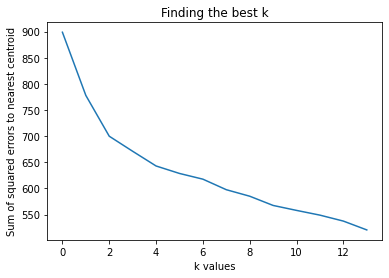

In [105]:
# Before clustering we have to determine a good k for kMeans clustering
X = df_venue_categories.values
print(f"Shape of the input data: {X.shape}")

def build_clusterer(k):
    clusterer = KMeans(k).fit(X)
    
    return clusterer.inertia_

ks = [k for k in range(1,15)]
scores = [build_clusterer(k) for k in ks]

plt.xlabel("k values")
plt.ylabel("Sum of squared errors to nearest centroid")
plt.title("Finding the best k")
plt.plot(scores)
plt.show()

It seems like a good value for k is 3. We will use this while going on.

In [106]:
# Reading from this plot gives us
k = 3

# Use this k for our clusterer
clusterer = KMeans(3).fit(X)

# Add the cluster to the data
y = clusterer.predict(X)


# Add this information to the other dataframes
df_tmp = pd.DataFrame({"name": df_venue_categories.index, "cluster": y})
df_stations = df_stations.merge(df_tmp, on="name")
df_venues = df_venues.merge(df_tmp, left_on="station name", right_on = "name")

df_stations.head()

,name,place,district,type of transport,lines,longitude,latitude,cluster
0,Nürnberger Straße,Stuttgart,Stuttgart,S-Bahn;R-Bahn;Nachtbus;Stadtbahn,"S2,S3,R2,R3,U1,N6",9.234577,48.806560,0
1,Leinfelden,Leinfeld.-Echterd.,Leinfelden,Bus;S-Bahn;Stadtbahn,"S2,S3,S6,U5,35,38,E,82,86,826,826A",9.142860,48.696419,0
2,Höfingen,Leonberg,Höfingen,S-Bahn,"S6,S60",9.026181,48.815034,1
3,Sommerrain,Stuttgart,Stuttgart,Bus;R-Bahn;S-Bahn,"S2,S3,R2,R3,54,58",9.248343,48.815245,0
4,Malmsheim,Renningen,Malmsheim,S-Bahn,S6,8.905106,48.771836,1


In [107]:
# Check if values are updated correctly
df_venues.head()

,station name,venue id,venue name,venue address,venue latitude,venue longitude,venue categories,name,cluster
0,Nürnberger Straße,4c694a008e7c0f47862cdf0f,S+U Stuttgart Nürnberger Straße,Nürnberger Str.,48.804363,9.235662,Light Rail Station,Nürnberger Straße,0
1,Nürnberger Straße,4f3668a1e4b0aa62a107c15d,Agip Service Station,Nürnberger Straße 18,48.805813,9.233371,Gas Station,Nürnberger Straße,0
2,Nürnberger Straße,4c62a9097c9def3b4a81d31c,TOTAL Tankstelle,Nuernberger Str. 9,48.806046,9.232760,Gas Station,Nürnberger Straße,0
3,Nürnberger Straße,4c403e24e26920a1a48c5ce7,Amadeus Frisör,Nauheimerstrasse,48.805436,9.227753,Unknown,Nürnberger Straße,0
4,Nürnberger Straße,518920da498e0c6939ea0b60,Neckar Käpt'n,<NA>,48.808496,9.234980,Harbor / Marina,Nürnberger Straße,0


We can now plot this data similar to what we have done before but also including the information we just established.

In [108]:
## Create the map that we have already seen before but add cluster coding

# Create a copy of the original dataframes
df_plot_main = df_stations[["name", "latitude", "longitude", "cluster"]]
df_plot_side = df_venues[["venue name", "venue latitude", "venue longitude", "cluster"]]

# Center on Stuttgart Main Station
df_main_stations = df_plot_main[df_plot_main["name"].str.match(".*Hauptbahnhof.*")]
latitude = df_main_stations["latitude"].mean()
longitude = df_main_stations["longitude"].mean()

# Additional functions for proper formating
cleaner = lambda x: x.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue")

# Color coding for different clusters
colors = ["green", "yellow", "orange", "brown", "black", "purple", "pink"]

## Create the map and the labels
map = folium.Map(location = (latitude, longitude), zoom_start=10)

# Create markers for venues
for _, (name, lat, long, cluster) in df_plot_side.iterrows():
    label = folium.Popup(cleaner(name))
    
    folium.CircleMarker(
        location=(lat,long),
        popup=label,
        color=colors[cluster],
        fill=True,
        radius=5,
        fill_opacity=1.0
    ).add_to(map)

# Create markers for stations
for _, (name, lat, long, cluster) in df_plot_main.iterrows():
    label = folium.Popup(cleaner(name))
    
    folium.CircleMarker(
        location=(lat,long),
        popup=label,
        color="blue",
        fill_color=colors[cluster],
        fill=True,
        radius=7,
        fill_opacity=1
    ).add_to(map)
    
# Create marker for the users current location
folium.CircleMarker(
    location=(latitude, longitude),
    popup=folium.Popup("Your Location"),
    color="red",
    fill=True,
    radius=10,
    fill_opacity=0.7
).add_to(map)

# Print a legend to stdout:
print("Marker Colors:")
for cluster in clusters:
    print(f"\tCluster '{cluster}': {colors[cluster]}")
    

map

Marker Colors:
	Cluster '0': green
	Cluster '1': yellow
	Cluster '2': orange


### Analyzing the cluster
Now that we have succesfully introduced clusters for the different venues we can analyze the clusters and determine their charactersistics.

In [16]:
clusters = [x for x in range(0,k)]
categories = list(df_venues["venue categories"].unique())

print("Clusters:")
print(clusters)
print()
print("Categories:")
print(categories)

Clusters:
[0, 1, 2]

Categories:
['Light Rail Station', 'Gas Station', 'Unknown', 'Harbor / Marina', 'Hotel', 'Metro Station', 'Other Great Outdoors', 'Well', 'Train Station', 'Pizza Place', 'Dry Cleaner', 'Office', 'Auto Dealership', 'Bakery', 'Parking', 'Convention Center', 'Café', 'Supermarket', 'Bank', 'Pet Service', 'Fried Chicken Joint', 'Athletics & Sports', 'German Restaurant', "Doctor's Office", 'Factory', 'College Gym', 'Automotive Shop', 'Restaurant', 'Hostel', 'Hardware Store', 'Nightclub', 'Cultural Center', 'Miscellaneous Shop', 'Bus Line', 'Salon / Barbershop', 'Italian Restaurant', 'Diner', 'Historic Site', 'Platform', 'Turkish Restaurant', 'Post Office', 'General College & University', 'Shoe Store', 'Plaza', 'Outlet Store', 'Massage Studio', 'Clothing Store', 'Museum', 'Indian Restaurant', 'Bus Stop', 'Modern European Restaurant', 'City Hall', 'Brewery', 'Veterinarian', 'Event Service', 'Doner Restaurant', 'Field', 'College Quad', 'Medical Center', 'Shopping Mall', 'Ba

We can count the categories per cluster as well as the total occurence of clusters to calculate probabilities we can later use to guide user interaction.

In [109]:
# A dict-like data structure that returns a default value for
# elements that are not in the dict
from collections import defaultdict

cluster = 0

def get_ordered_venue_categories(cluster_name):
    # Get all the venues that belong to a cluster
    venues = df_venues[df_venues["cluster"] == cluster_name]
    categories = venues["venue categories"].values

    # Count how often each categorie appears
    occurence_numbers = defaultdict(int) # default value: 0
    for c in categories: occurence_numbers[c] += 1

    # Sort occurence numbers by number of occurence in descending order
    occurence_numbers = [ (k,occurence_numbers[k]) for k in occurence_numbers.keys()]
    occurence_numbers.sort(key=lambda x: x[1], reverse=True)

    # Normalize number over total number of elements
    total = sum([x[1] for x in occurence_numbers])
    occurence_numbers = [(k, float(v) / total) for (k,v) in occurence_numbers]

    # Print top seven venue types for each cluster
    print(f"-- Cluster: {cluster_name} -----")
    for i, (c, p) in enumerate(occurence_numbers[:17]):
        print(f"\t#{i+1} categorie: '{c}' with {p*100}%")
    print()
    
    return occurence_numbers

# Print information on the top categories in the cluster and build a dict that
# contains for each categorie in what percentage of a clustertype it occurs
cluster_categorie_list = defaultdict(list)
for cluster in clusters:
    tmp = get_ordered_venue_categories(cluster)
    cluster_categorie_list[cluster] = tmp
        
total_venues = df_venues.shape[0]

-- Cluster: 0 -----
	#1 categorie: 'Light Rail Station' with 10.363636363636363%
	#2 categorie: 'Bakery' with 5.2727272727272725%
	#3 categorie: 'Hotel' with 3.6363636363636362%
	#4 categorie: 'Gas Station' with 3.4545454545454546%
	#5 categorie: 'Unknown' with 3.090909090909091%
	#6 categorie: 'Office' with 2.727272727272727%
	#7 categorie: 'German Restaurant' with 2.5454545454545454%
	#8 categorie: 'Supermarket' with 2.0%
	#9 categorie: 'Train Station' with 1.8181818181818181%
	#10 categorie: 'Building' with 1.8181818181818181%
	#11 categorie: 'Parking' with 1.6363636363636365%
	#12 categorie: 'Café' with 1.4545454545454546%
	#13 categorie: 'Italian Restaurant' with 1.4545454545454546%
	#14 categorie: 'Factory' with 1.4545454545454546%
	#15 categorie: 'Bus Stop' with 1.4545454545454546%
	#16 categorie: 'Bar' with 1.4545454545454546%
	#17 categorie: 'Pizza Place' with 1.2727272727272727%

-- Cluster: 1 -----
	#1 categorie: 'Unknown' with 28.999999999999996%
	#2 categorie: 'Light Rail 

In [110]:
# Calculat some statistical probabilities 
    
# We can also compute the propabilitie for each cluster occuring
prop_cluster = defaultdict(int) # P(Cluster = cluster)
for cluster in clusters:
    associated_venues = df_venues[df_venues["cluster"] == cluster].shape[0]
    prop = associated_venues / total_venues
    prop_cluster[cluster] = prop

# And the probability for each categorie occuring
prop_categorie = defaultdict(int) # P(Categorie = categorie)
for categorie in categories:
    associated_venues = df_venues[df_venues["venue categories"] == categorie].shape[0]
    prop = associated_venues / total_venues
    prop_categorie[categorie] = prop
    
def statistical_information(categorie):
    prop = prop_categorie[categorie]
    
    print(f"Probability of any venue being of type '{categorie}': {prop*100}%")

We now have the means to infer statistical information about each venue categorie:

In [111]:
# Example: We want to know how many of the venues are bakeries?
statistical_information("Bakery")

Probability of any venue being of type 'Bakery': 4.285714285714286%


### Using this data to guide users
We can use this refined data to help users making decisions. For the following segment we will introduce a examplary user. We simulate what he might do and how we can use this data for his benefit.
We will do this by giving him some intrests and how they might influence the decision he will make.

In [112]:
# User data: This is exemplary user data. In reality such data could be gained by
# asking user on account generation or by evaluating their history when using the app.
USER_INTERESTS = ["Bar", "Hardware Store", "German Restaurant", "Turkish Restaurant", "Café"]

We can use the users interest and the probability of the categories being in a cluster as caluclated before to 
calculate a score for each cluster.

In [114]:
# Sum up the probabilities of the user interests for each cluster
cluster_ratings = defaultdict(float)

for cluster in clusters:    
    cluster_rating = 0.0
    for (categorie, prop) in cluster_categorie_list[cluster]:
        if categorie in USER_INTERESTS:
            cluster_rating += prop
        
    cluster_ratings[cluster] = cluster_rating
    
for cluster in clusters:
    print(f"Cluster '{cluster}': {cluster_ratings[cluster]*100}% of venues in this cluster apeal to the user.")
print()

# Produce a ordered list where the first element is the most fitting
rank = [(k,v) for (k,v) in cluster_ratings.items()]
rank.sort(key=lambda x: x[1])
print(f"Ordered ranking: {rank}")

Cluster '0': 5.636363636363637% of venues in this cluster apeal to the user.
Cluster '1': 3.0000000000000004% of venues in this cluster apeal to the user.
Cluster '2': 5.555555555555556% of venues in this cluster apeal to the user.

Ordered ranking: [(1, 0.030000000000000002), (2, 0.05555555555555556), (0, 0.056363636363636366)]


Now we have established a ranking on which cluster is most suiting to the user.

Now we can make data driven suggestions to the user information concerning where he can go to have an interesting time. Let's at first assume he or she wants to go to a Cafè. Then we can find a fitting one like this:

In [116]:
# Target that the user establishe
TARGET = "Café"

# Extract data
interesting_columns = ["station name", "venue name", "venue address", "venue latitude", "venue longitude", "cluster"]
suited_venues = df_venues[df_venues["venue categories"] == TARGET][interesting_columns]

# We can now iterate thorugh the cluster ranking to find venues in a interesting area for the customer
suggestions = None
for (cluster, _) in rank:
    suited_venues_in_cluster = suited_venues[suited_venues["cluster"] == cluster]

    is_empty = suited_venues_in_cluster.shape[0] == 0
    if is_empty:  # No fitting venues
        print(f"No fitting venue in cluster '{cluster}'.")
    else: # We found a result 
        suggestions = suited_venues_in_cluster
        print(f"Found fitting venue in cluster '{cluster}'.")
        break

No fitting venue in cluster '1'.
Found fitting venue in cluster '2'.


We can now present this information to the user:

In [117]:
if suggestions is None:
    print("No results found, please try something else.")
else:
    print("We found the following suggestions:")
    for _, (sn, vn, va, vlat, vlong, _) in suggestions.iterrows():
        print(f"  The venue '{vn}' at '{va}' might interest you, you can reach it via '{sn}'-station.")

We found the following suggestions:
  The venue 'Trabucco' at 'Neckarstrasse 3/1' might interest you, you can reach it via 'Esslingen (N)'-station.
  The venue 'Opus' at 'Berliner Str. 1' might interest you, you can reach it via 'Esslingen (N)'-station.


You could further refine this, by adding a map marking the locations and their nearest stations on a map or you could sort the results by nearness to the current location. One could also include other information of lower scored cluster.

In another case, the user might not have something specific in mind and would instead want a recommendation on where to go to spend some time. In this case we can send him to a station that is the center of a cluster of the type he prefers. 
We will order the result according to distance to the user's current location so as to minimize the distance he has to travel. Note that the distance in this project will be calculated as the physical distance. In a more complex scenario it might be better to use the travel time via train instead, but this is too complex for this project.

In [118]:
# A function to calculate distances given latitude and longitude
def haversine_dist(c1, c2):
    """
        Calculate the distance between two geo point.
        This is known as the haversine distance.
        Source:
        https://janakiev.com/blog/gps-points-distance-python/
    """
    r = 6372800  # Earth radius in meters

     # Convert to radians
    phi1, phi2 = math.radians(c1[0]), math.radians(c2[0])
    dphi       = math.radians(c2[0] - c1[0])
    dlambda    = math.radians(c2[1] - c1[1])
    
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*r*math.atan2(math.sqrt(a), math.sqrt(1 - a))

# The clustertype the user preferes
prefered_cluster = rank[0][0]
recommendations = df_stations[df_stations["cluster"] == prefered_cluster][["name", "latitude", "longitude"]]

# We will assume that the user is currently still at main station
user_lat = df_main_stations["latitude"].mean()
user_long = df_main_stations["longitude"].mean()
user_c = (user_lat, user_long)

# Calculate distances and sort by distance
station_rank = [(name, haversine_dist(user_c, (lat,long))) for _, (name, lat, long) in recommendations.iterrows()]
station_rank.sort(key=lambda x: x[1], reverse=False)

print(f"We think you will like clusters of type '{prefered_cluster}'.")
print("Here are stations whose surrounding you might enjoy (beginning with the nearest):")
for (station,_) in station_rank[:10]:
    print(f"  Station '{station}'")
    
recommendations.head()

We think you will like clusters of type '1'.
Here are stations whose surrounding you might enjoy (beginning with the nearest):
  Station 'Neckarpark'
  Station 'Rommelshausen'
  Station 'Höfingen'
  Station 'Oberesslingen'
  Station 'Stetten-Beinstein'
  Station 'Endersbach'
  Station 'Zell'
  Station 'Beutelsbach'
  Station 'Nord'
  Station 'Rutesheim'


,name,latitude,longitude
2,Höfingen,48.815034,9.026181
4,Malmsheim,48.771836,8.905106
5,Rutesheim,48.790266,8.960216
10,Benningen (N),48.943780,9.244285
15,Stetten-Beinstein,48.811961,9.352402


In [119]:
print(user_c)
df_stations[df_stations["name"].isin(["Hauptbahnhof (tief)", "Neckarpark"])]

(48.78392867, 9.1813194235)


,name,place,district,type of transport,lines,longitude,latitude,cluster
50,Neckarpark,Stuttgart,Stuttgart,S-Bahn,"S1,S11",9.241069,48.791961,1
54,Hauptbahnhof (tief),Stuttgart,Stuttgart,S-Bahn,"S1,S2,S3,S4,S5,S6,S11,S60",9.179846,48.782982,0


In this notebook you have seen how one can use data to help a user in decision making. I hope you found it interesting.

## The End